# Getting started with `mav_sim`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mav_sim.simulator import MavSim
%matplotlib inline

pybullet build time: Jun 16 2022 23:11:14


## 1) Load the simulator
"HX14.yaml" contains the parameters for a ~0.5 m, 1.3 Kg hexarotor. The simulator prints the loaded parameters. 

In [2]:
mav_sim = MavSim("HX14.yaml")

argv[0]=
[MavSim] Loading URDF: /Users/andreatagliabue/octobee_acados/mav_sim/mav_sim/assets/robot/HX14.urdf.
Using HX14 allocation matrix
[MavSim] Loaded Params: 
HX14:
  arm_length: 0.165
ctr:
  angular_rate_gains: [0.33, 0.33, 0.33]
  attitude_gains: [1.1, 1.1, 1.1]
  gravity: 9.80655
  inertia: [0.0082, 0.0082, 0.0126]
  mass: 1.3
  open_loop: False
octabee:
  lx: 0.22
  ly: 0.12
rbt:
  act_delay: 0.0
  angvel_drag: 1e-05
  inertia: [0.0082, 0.0082, 0.0126]
  inverse_thrust_curve_ccw: [6.776583, 0.0]
  inverse_thrust_curve_cw: [5.204733, 0.0]
  lin_drag_constant: 0.1
  mass: 1.3
  max_thrust_per_g: 1.5
  max_thrust_per_motor: 12.95
  motor_spin_direction: [-1, 1, -1, 1, -1, 1]
  n_motors: 6
  prop_thrust_to_torque_coeff: 0.02
  quad_drag_constant: 0.01
  thrust_curve_ccw: [0.147567, 0.0]
  thrust_curve_cw: [0.192133, 0.0]
  torque_curve_ccw: [0.135532, 0.0]
  torque_curve_cw: [0.104094, 0.0]
  torque_limit: 10.0
sim:
  attitude_control_step_freq: 100
  gravity: 9.80655
  gui: False

## 2) Step the simulation with a position control loop
In this example we close a position loop using a linear feedback controller.<br>
We define the state vector to contain position, velocity, orientation (roll, pitch).<br>
The actions to be sent to the attitude controller are a desired roll, pitch and thrust. 
We assume yaw to be fixed to 0.

In [3]:
# Gain matrix for position controller. 
# Can be obtained via LQR and an hover-linearized model of the robot. 
K = np.array([[0.0, 1.2, 0.0, 0.0, 1.12, 0.0, -1.37, 0.0], 
             [-1.2, 0.0, 0.0, -1.12, 0.0, 0.0, 0.0, -1.36], 
             [0.0, 0.0, -5.6, 0.0, 0.0, -5.07, 0.0, 0.0]])

In [4]:
from mav_sim.config import cfg          # exposes the parameters
from mav_sim.utils import rotm_from_euler

# This steps at the cfg.pos_control_step_freq. 
# So N_steps = 100 and cfg.pos_control_step_freq = 10 Hz corresponds
# to 10s of simulation 
N_steps = 100

# Initial state of the robot
# (here we set position, velocity, roll, pitch in gravity aligned frame
#  which we use to define an "observation") 
x0 = np.array([0.5, 0.5, 0.5, 0, 0, 0, 0.1, 0.1])

# Desired state
x_des = np.array([1.0, 1.0, 1.0, 0, 0, 0, 0.0, 0.0])

# Log
obs_hist = np.zeros((N_steps, 8))
act_hist = np.zeros((N_steps, 3))
B_omega_hist = np.zeros((N_steps, 3))
yaw_hist = np.zeros((N_steps, 1))
yaw_cmd_hist = np.zeros((N_steps, 1))

# Initializes robot at initial state
obs = mav_sim.reset_to_state(W_pos=x0[0:3], W_vel=x0[3:6], B_rpy=np.concatenate((x0[6:8], np.zeros(1))))

# Step simulation
for i in range(N_steps): 
    
    # Apply position control
    act = K@(obs - x_des)
    
    # Compute desired thrust, roll, pitch assuming zero yaw\
    ref_yaw = 0.0
    W_R_B_ref = rotm_from_euler([act[0], act[1], ref_yaw])                          # Desired roll, pitch, yaw
    B_thrust = np.array([0.0, 0.0, (act[2] + cfg.sim.gravity)*cfg.ctr.mass])    # Desired thrust
    B_omega_ref = np.zeros(3)                                                   # Desired angular velocity
    
    # Step simulation and returns a convenient representation of the state 
    # (pos, vel, roll pitch in yaw-fixed frame, an "observation" for e.g., gym environment).
    # Alternatively, build your own custom state by calling
    # s = mav_sim.get_state() after stepping
    obs = mav_sim.step_attitude_control_and_dynamics(B_thrust = B_thrust, W_R_B_ref = W_R_B_ref, B_omega_ref = B_omega_ref)
    
    obs_hist[i, :] = obs
    B_vel_lin, B_omega = mav_sim.get_B_velocities()
    B_omega_hist[i, :] = B_omega
    act_hist[i, :] = act
    yaw_hist[i, :] = mav_sim.get_yaw()
    yaw_cmd_hist[i, :] = ref_yaw

time = np.linspace(start=0.0, stop=(N_steps-1)/cfg.sim.pos_control_step_freq, num=N_steps)

## 3) Visualize the trajectory

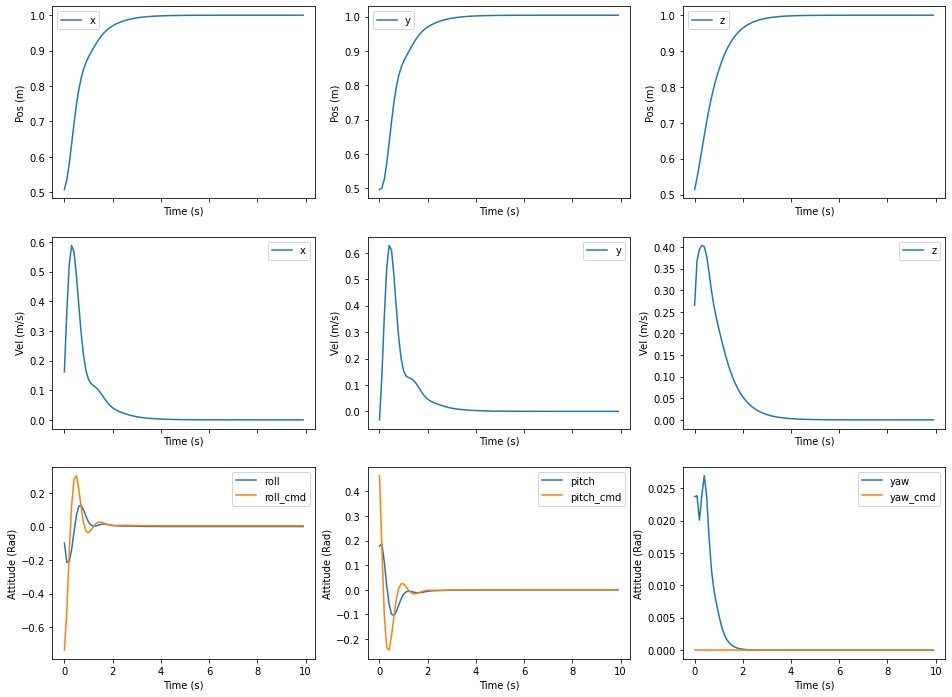

In [5]:
def plot_trajectories(time, obs_hist, act_hist, yaw_hist, yaw_cmd_hist):
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(16, 12))
    labels = ["x", "y", "z"]
    for ax in range(3):
        # position
        axs[0, ax].plot(time, obs_hist[:, ax], label=labels[ax])
        axs[0, ax].set_ylabel('Pos (m)')
        axs[0, ax].legend()
            
        # velocity
        axs[1, ax].plot(time, obs_hist[:, ax + 3], label=labels[ax])
        axs[1, ax].set_ylabel('Vel (m/s)')
        axs[1, ax].legend()

    # Roll, pitch
    signal_labels = ['roll', 'pitch']
    cmd_signal_labels = ['roll_cmd', 'pitch_cmd']
    for ax in range(2):
        axs[2, ax].plot(time, obs_hist[:, ax + 6], label=signal_labels[ax])    
        axs[2, ax].plot(time, act_hist[:, ax], label=cmd_signal_labels[ax])
        axs[2, ax].set_ylabel("Attitude (Rad)")
        axs[2, ax].legend()
    
    axs[2, 2].plot(time, yaw_hist, label='yaw')
    axs[2, 2].plot(time, yaw_cmd_hist, label='yaw_cmd')
    axs[2, 2].set_ylabel("Attitude (Rad)")
    axs[2, 2].legend()

    # Time
    [[axs[i, j].set_xlabel("Time (s)") for i in range(3)] for j in range(3)]

    plt.show()

plot_trajectories(time, obs_hist, act_hist, yaw_hist, yaw_cmd_hist)

## 3) visualize an image from the onboard camera

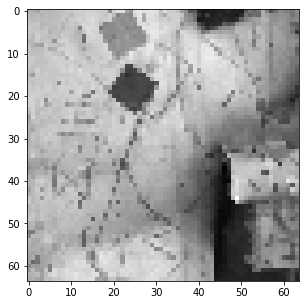

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
(rendered_img_v1, _) = mav_sim.get_onboard_camera_observation() # it is also possible to generate images at a different pose for e.g., data augmentation
axs.imshow(rendered_img_v1[0, :], cmap='gray')